![](files/Fasshauer.png)

In [81]:
using SpecialFunctions, Laplacians, KernelMatrices, LinearAlgebra, Plots

function dist(x, z, d = 2)
    return (sum((x .- z).^d))^(1/d)
end

function matkern(dis::Number, epsilon::Number, m::Number, d::Int = 2)
    if dis == 0.0 
        return 1.0
    else
        return besselk(m-d/2, epsilon*dis)*(epsilon*dis)^(m-d/2)
    end
end

matkern (generic function with 2 methods)

[103, 134, 135, 136, 165, 166, 167, 168, 169, 186, 198, 199, 200, 217, 218, 219, 231, 246, 248, 249, 250, 251, 252, 277, 278, 279, 281, 282, 283, 303, 308, 309, 310, 311, 312, 314, 334, 335, 336, 341, 342, 343, 365, 366, 367, 368, 369, 374, 398, 399, 400, 431]
There are 52 missing.


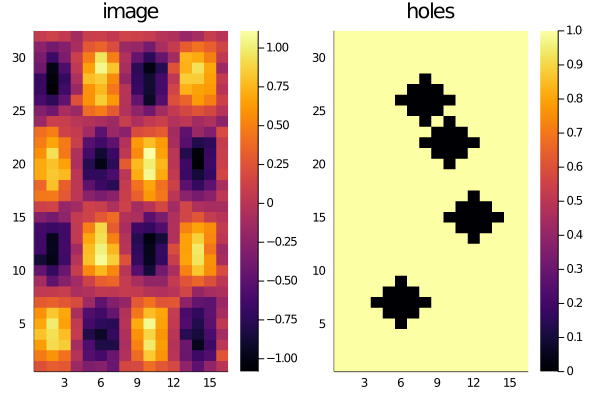

In [82]:
L = 32
K = 16
a_num = (L,K) # length vectors for a 2D problem
x1 = 1:a_num[1]
x2 = 1:a_num[2]
d = length(a_num)
img = sin.(2*pi*x1/16)*sin.(2*pi*x2'/8) + randn(a_num)*0.1


cent = [(7,6), (15,12), (22,10), (26, 8)]
rad = 2.0

function prod_dot(m)
    mas = m[1]
    for i = 2:length(m)
        mas .*= m[i]
    end
    return mas
end

mask = map(c->broadcast(+, (x1 .- c[1]).^2, (x2 .- c[2])'.^2) .> rad^2, cent)
mask = prod_dot(mask)

# Find where the data are missing
inds = sortperm(mask[:])
S = L*K-sum(mask)
missing_inds = inds[1:S]
println(missing_inds)
nonmissing_inds = inds[(S+1):end]

println("There are $S missing.")

p1 = heatmap(img, title = "image")
p2 = heatmap(mask, title = "holes")

plot(p1,p2,layout=(1,2))

From Rasmussen and Williams book:
![](files/RW_GP_Pred.png)

In [83]:
# No noise is assumed, sigsq_n = 0

xx = [[x,y] for x in x1 for y in x2]
xxyy = [(x,y) for x in xx[inds] for y in xx[inds]]
dis = reshape(map(x -> dist(x...), xxyy), (512, 512))

epsilon = 0.22
m = 2
M = matkern.(dis, epsilon, m)

chK = cholesky(M[nonmissing_inds, nonmissing_inds])
alpha = chK.L'\(chK.L\img[nonmissing_inds])
fbar = M[nonmissing_inds,missing_inds]'*alpha

52-element Array{Float64,1}:
 -0.021983376962380063
 -0.2423055840700883
 -0.004335570659677046
  0.009574440747620372
 -0.8038100048359276
 -0.4595744401872466
 -0.15313550091532946
  0.3110050428612823
  0.6143170180508548
  0.7757935910208573
  0.1680859757451003
  0.4092782308542766
  0.3773802303605578
  ⋮
  0.23688346972410557
  0.16935931248669078
 -0.04255597493723684
 -0.07875455787354468
 -0.11437561881029268
 -0.39336107077585325
 -0.3918601585401902
 -0.21472326237742578
  0.4004482200049182
  0.38722138039148035
  0.17598746893135342
  0.7005629954495376

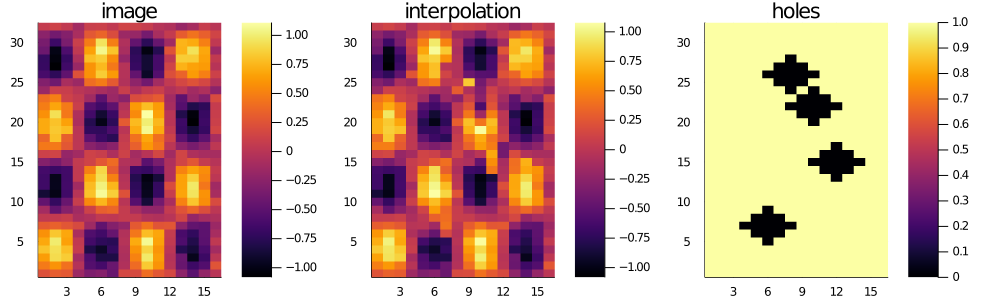

In [84]:
img_int = copy(img)
img_int[missing_inds] = fbar

p3 = heatmap(img_int, title="interpolation")

plot(p1,p3,p2,layout=(1,3),size=(1000,300))

In [85]:
hcat(img[missing_inds], fbar)

52×2 Array{Float64,2}:
  0.187526    -0.0219834
 -0.567803    -0.242306
 -0.14625     -0.00433557
 -0.0462431    0.00957444
 -0.740943    -0.80381
 -0.646284    -0.459574
 -0.483669    -0.153136
  0.0423653    0.311005
  0.320279     0.614317
  0.84624      0.775794
 -0.454301     0.168086
 -0.292449     0.409278
  0.0329138    0.37738
  ⋮           
  0.633861     0.236883
  0.29925      0.169359
 -0.0466094   -0.042556
 -0.0488095   -0.0787546
 -0.0597061   -0.114376
 -0.131177    -0.393361
  0.00623689  -0.39186
 -0.0971309   -0.214723
  0.516197     0.400448
  0.145966     0.387221
  0.145842     0.175987
  0.267733     0.700563